# Model Training
Di sesi kedua kita akan melakukan pembuatan train dan test data generator. Sebelumnya datasets yang bercampur antara Female dan Male akan dipiliah terlebih dahulu.

In [3]:
import os
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import keras
from keras import preprocessing
from keras import layers
from keras import models
from keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns

## Meload Male Attribute
Melakukan load terhadap file atribut, dan melakukan pengacakan baris.

In [55]:
df = pd.read_csv("CelebA/male_attribute.csv")
df.head()

,Image_Id,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,-1


In [56]:
df_shuffled = df.sample(frac=1, random_state=None)
df_shuffled.head()

,Image_Id,Male
4998,202357.jpg,-1
526,021962.jpg,-1
1760,070826.jpg,-1
752,030546.jpg,-1
2724,110574.jpg,-1


## Membuat directory untuk dataset
Directori yang dibuat adalah directory Train dan Test. Dimana masing-masing terdapat 2 kategori kelas di dalamnya yaitu Male dan Female.

In [57]:
!rm -drf Dataset

!mkdir Dataset
!mkdir Dataset/Train
!mkdir Dataset/Test

!mkdir Dataset/Train/Male
!mkdir Dataset/Train/Female

!mkdir Dataset/Test/Male
!mkdir Dataset/Test/Female

## Pengelompokan dataset berdasar kelas
Dataset akan dipisah menjadi 4000 untuk Training, dan 1000 untuk Test.
Dimana pada dataaset Training akan dibagi secara seimbang antara kelas Male dan Female, masing-masing 2000.
Gambar akan dikemlompkan berdasarkan folder yang sesuai.

In [58]:
train_num = 4000
source_path = "CelebA/Images"
males = df_shuffled["Male"]
images = df_shuffled["Image_Id"]
male_count = 0
female_count = 0
for i in range(len(males)):
     if males[i] == -1:
        if female_count < train_num/2:
            shutil.copyfile(f"{source_path}/{images[i]}", f"Dataset/Train/Female/{images[i]}")
            female_count += 1
        else:
            shutil.copyfile(f"{source_path}/{images[i]}", f"Dataset/Test/Female/{images[i]}")
     else:
        if male_count < train_num/2:
            shutil.copyfile(f"{source_path}/{images[i]}", f"Dataset/Train/Male/{images[i]}")
            male_count += 1
        else:
            shutil.copyfile(f"{source_path}/{images[i]}", f"Dataset/Test/Male/{images[i]}")

Setelah melakukan pengelompokan kelas, ditemukan bahwa terdapat 2000 train data untuk Female, 2000 train data untuk Male, 953 test data untuk Female, dan 47 test data untuk Male

In [59]:
!ls 'Dataset/Train/Female/'  | wc -l
!ls 'Dataset/Train/Male'  | wc -l
!ls 'Dataset/Test/Female'  | wc -l
!ls 'Dataset/Test/Male'  | wc -l

2000
2000
953
47


## Pembuatan train data dan validation data
Train data dibuat menggunakan fungsi ImageDataGenerator pada keras, dengan beberapa perlakuan seperti melakukan normalisasi dan augmentasi.
Data image size menggunakan dimensi (299, 299), dan batch 128
Train data akan displit 80:20, sehingga mendapatkan 3200 data train, dan 800 data validation.

In [60]:
image_size = (299, 299)
batch_size = 128

train_dir = 'Dataset/Train'

train_datagen = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=32,
    subset="training"
)

valid_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=32,
    subset="validation"
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Visualisasi train data
Beberapa train data akan divisualisasikan sebagai berikut:

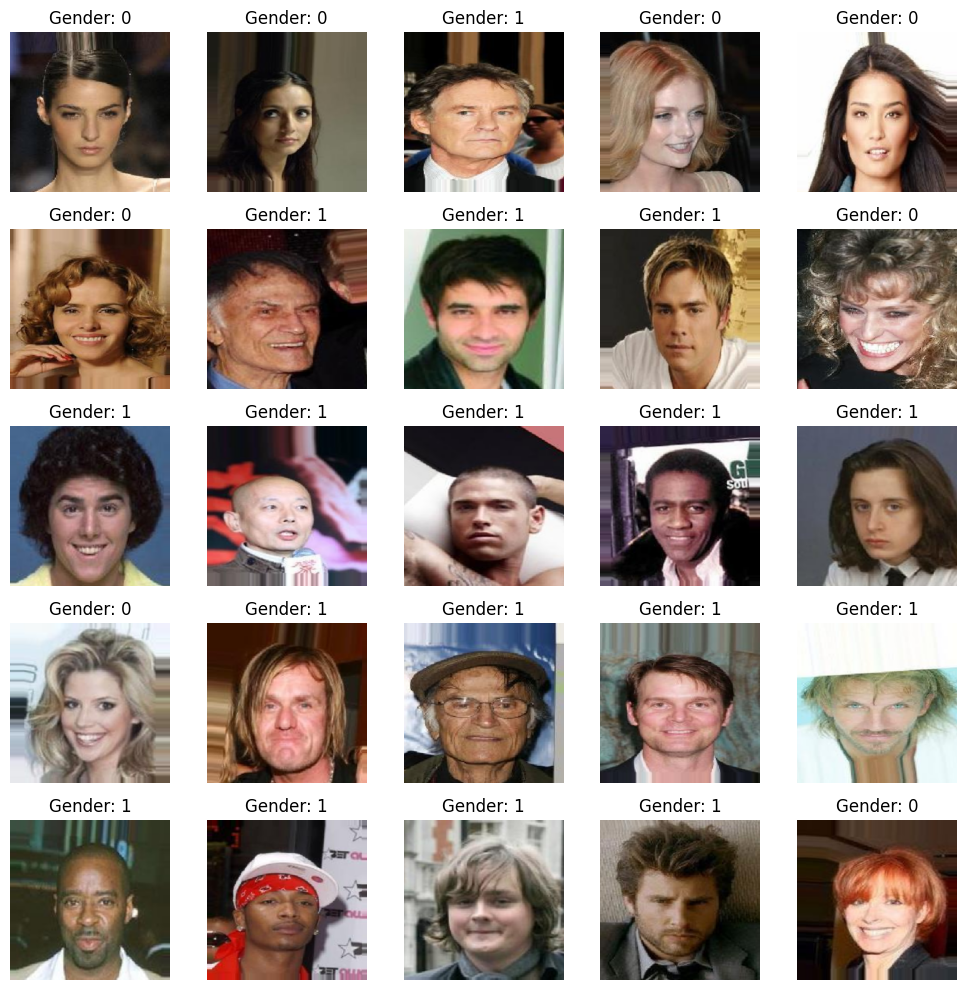

In [61]:
batch = train_generator.next()
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(batch[0][index])
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Gender: {batch[1][index].argmax()}')

plt.tight_layout()
plt.show()

## Pembuatan model dengan InceptionV3 module
Modul dibuat berdasarkan InceptionV3 dengan dimensi masukan (299, 299, 3)
Hasil keluaran menggunakan aktifasi softmax 2 kelas.

In [62]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [63]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(1024, activation='relu')(x)

predictions = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Training model
Parameter yang digunakan epochs 20

In [64]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=20)


Epoch 1/20
25/25 [==============================] - 109s 3s/step - loss: 0.3440 - accuracy: 0.8847 - val_loss: 1.1507 - val_accuracy: 0.5050
Epoch 2/20
25/25 [==============================] - 77s 3s/step - loss: 0.0959 - accuracy: 0.9634 - val_loss: 0.9487 - val_accuracy: 0.5088
Epoch 3/20
25/25 [==============================] - 79s 3s/step - loss: 0.0568 - accuracy: 0.9775 - val_loss: 0.5250 - val_accuracy: 0.7437
Epoch 4/20
25/25 [==============================] - 78s 3s/step - loss: 0.0523 - accuracy: 0.9822 - val_loss: 0.5442 - val_accuracy: 0.8062
Epoch 5/20
25/25 [==============================] - 79s 3s/step - loss: 0.0351 - accuracy: 0.9869 - val_loss: 0.6297 - val_accuracy: 0.8200
Epoch 6/20
25/25 [==============================] - 79s 3s/step - loss: 0.0390 - accuracy: 0.9837 - val_loss: 0.4372 - val_accuracy: 0.8512
Epoch 7/20
25/25 [==============================] - 80s 3s/step - loss: 0.0380 - accuracy: 0.9866 - val_loss: 2.2815 - val_accuracy: 0.7225
Epoch 8/20
25/25 [=

## Visualisasi hasil training
Akurasi mulai mendatar di 95%

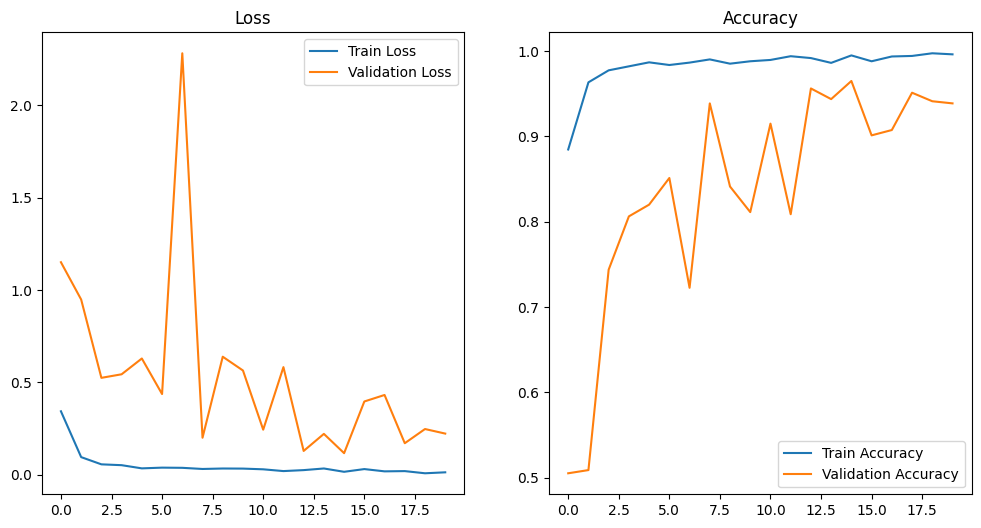

In [65]:
# plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

## Evaluasi model dengan test data
Dengan 1000 test data, mendapatkan hasil test akurasi seberasr 0.98%

In [8]:
image_size = (299, 299)
batch_size = 128

test_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255)

test_path = "Dataset/Test"
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
  )

# Evaluate the model on test data
evaluation = model.evaluate(test_generator)

# Print evaluation metrics
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

Found 1000 images belonging to 2 classes.
8/8 [==============================] - 44s 5s/step - loss: 0.0570 - accuracy: 0.9850
Test Loss: 0.05698641762137413
Test Accuracy: 0.9850000143051147


## Model Confusion Matrix 

In [9]:
# Menggunakan generator data validasi untuk mendapatkan prediksi dan label sebenarnya
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Mengonversi prediksi probabilitas menjadi label kategori
y_pred_labels = np.argmax(y_pred, axis=1)

# Nama kelas dari generator data test
class_labels = list(test_generator.class_indices.keys())

8/8 [==============================] - 41s 5s/step


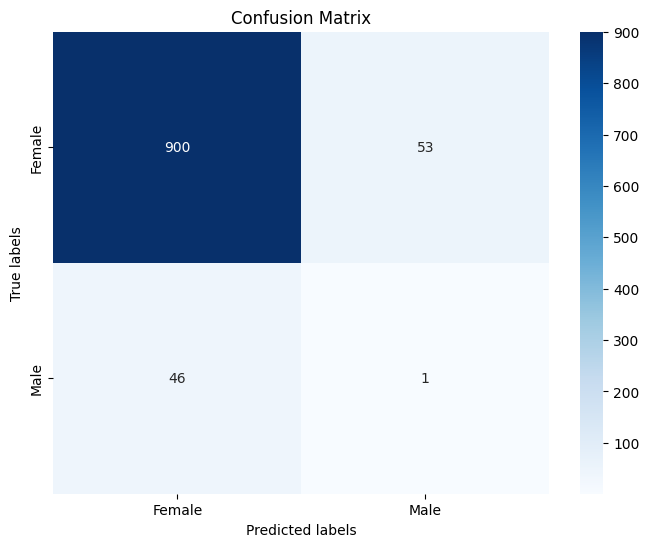

In [11]:
# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Membuat Evaluasi dengan data test seimbang

In [17]:
!mkdir Dataset/Test2
!mkdir Dataset/Test2/Male
!mkdir Dataset/Test2/Female

!cp -rf Dataset/Test/Male/* Dataset/Test2/Male/


mkdir: Dataset/Test2: File exists
mkdir: Dataset/Test2/Male: File exists
mkdir: Dataset/Test2/Female: File exists


In [19]:
!ls 'Dataset/Test2/Male'  | wc -l

      47


In [23]:
females = os.listdir('Dataset/Test/Female')
females = females[:47]
for file in females:
    shutil.copy(f'Dataset/Test/Female/{file}', f'Dataset/Test2/Female/{file}')
!ls 'Dataset/Test2/Female'  | wc -l

      47


In [24]:
image_size = (299, 299)
batch_size = 128

test_datagen = preprocessing.image.ImageDataGenerator(rescale=1./255)

test_path = "Dataset/Test2"
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
  )

Found 94 images belonging to 2 classes.


## Evaluasi Model

In [27]:
# Evaluate the model on test data
evaluation = model.evaluate(test_generator)

# Print evaluation metrics
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

1/1 [==============================] - 4s 4s/step - loss: 0.1257 - accuracy: 0.9574
Test Loss: 0.12565977871418
Test Accuracy: 0.957446813583374


In [28]:
# Menggunakan generator data validasi untuk mendapatkan prediksi dan label sebenarnya
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Mengonversi prediksi probabilitas menjadi label kategori
y_pred_labels = np.argmax(y_pred, axis=1)

# Nama kelas dari generator data test
class_labels = list(test_generator.class_indices.keys())

1/1 [==============================] - 4s 4s/step


## Confusion Matrix

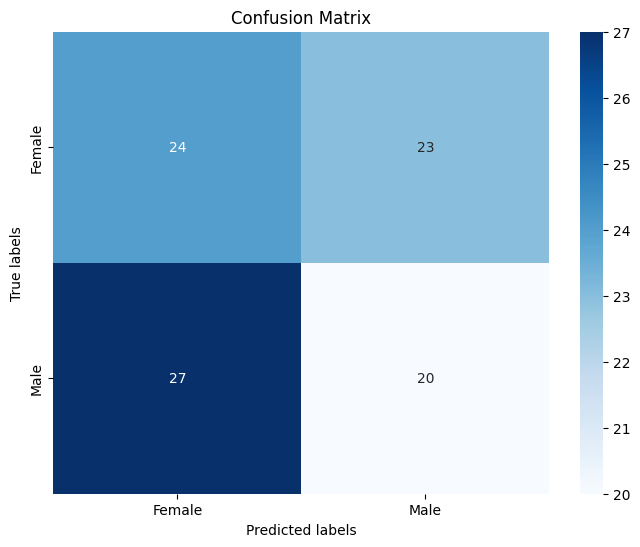

In [35]:
# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Akurasi untuk setiap kelas

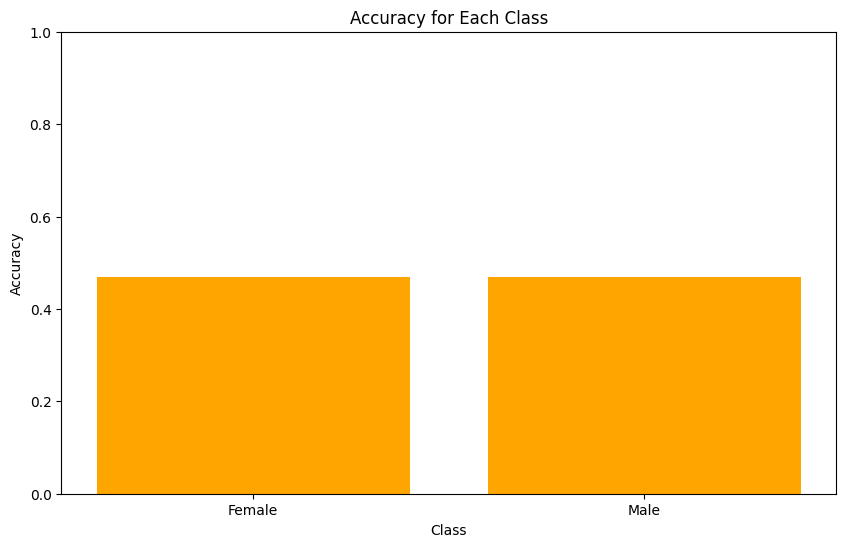

In [30]:
# Menghitung akurasi untuk setiap kelas
accuracy_per_class = accuracy_score(y_true, y_pred_labels)

# Plot akurasi untuk setiap kelas
plt.figure(figsize=(10, 6))
plt.bar(class_labels, accuracy_per_class, color='orange')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.ylim(0, 1)
plt.show()

## Recall untuk setiap kelas

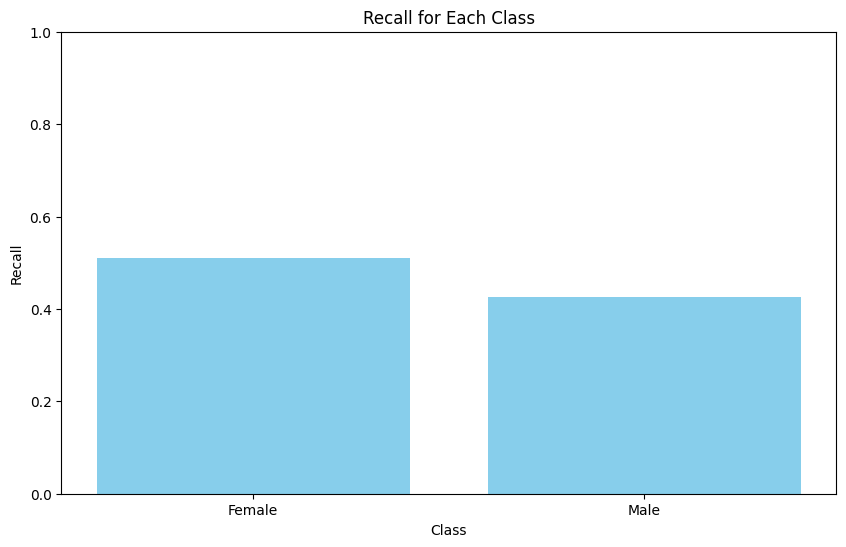

In [31]:
# Menghitung recall untuk setiap kelas
recall_per_class = recall_score(y_true, y_pred_labels, average=None)

# Plot recall untuk setiap kelas
plt.figure(figsize=(10, 6))
plt.bar(class_labels, recall_per_class, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for Each Class')
plt.ylim(0, 1)
plt.show()

## Presisi untuk setiap kelas

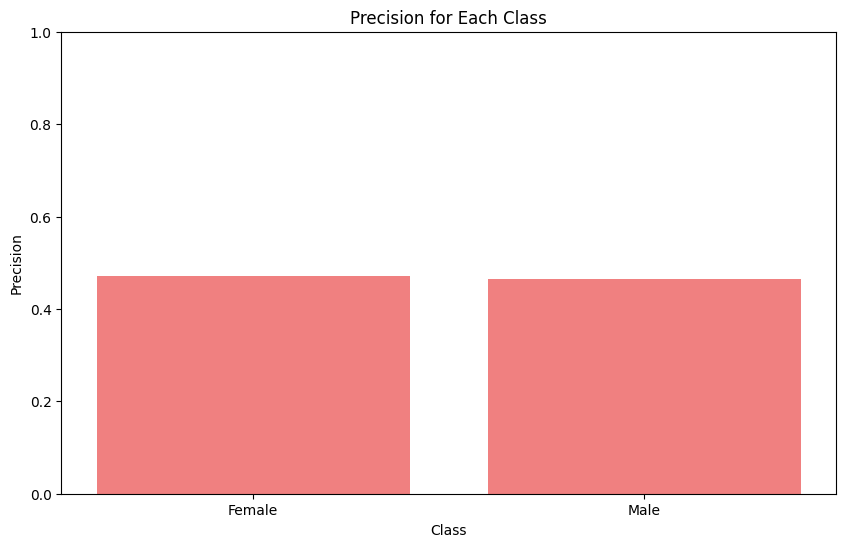

In [32]:
# Menghitung precision untuk setiap kelas
precision_per_class = precision_score(y_true, y_pred_labels, average=None)

# Plot precision untuk setiap kelas
plt.figure(figsize=(10, 6))
plt.bar(class_labels, precision_per_class, color='lightcoral')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for Each Class')
plt.ylim(0, 1)
plt.show()

## F1 Score untuk setiap kelas

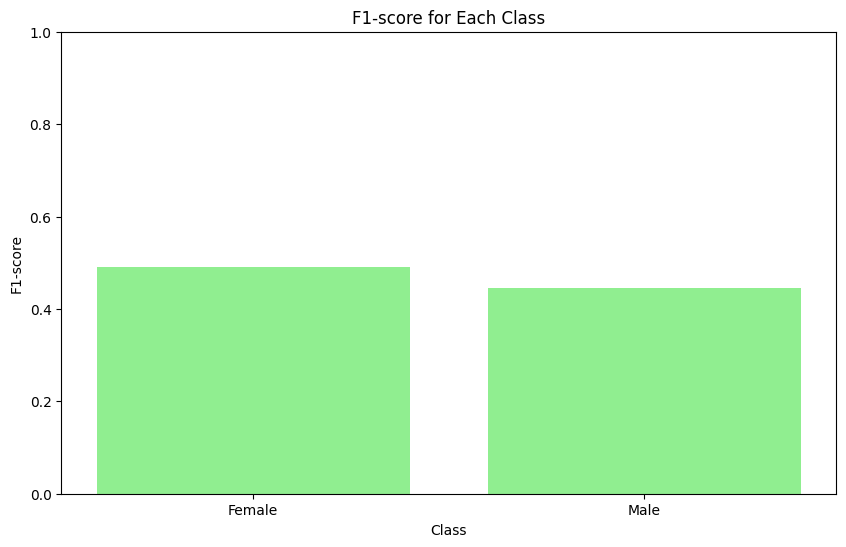

In [33]:
# Menghitung F1-score untuk setiap kelas
f1_per_class = f1_score(y_true, y_pred_labels, average=None)

# Plot F1-score untuk setiap kelas
plt.figure(figsize=(10, 6))
plt.bar(class_labels, f1_per_class, color='lightgreen')
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score for Each Class')
plt.ylim(0, 1)
plt.show()

In [7]:
model = models.load_model('models/inception_v3_categorical_epoch_20.keras')

## Menyimpan model ke file 

In [78]:
model.save("inception_v3_categorical_epoch_20.keras")